# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

## Students

* Team: `18`
* Students: `Quentin Bacuet, Ali Alami-Idrissi, Keshav Singh, Leandro Kieliger`
* Dataset: `US-Senators`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [2]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [3]:
ADJACENCY_PATH = '../data/adjacency_matrices/'
ADJACENCY_COSINE_PATH = ADJACENCY_PATH + 'cosine'
ADJACENCY_EUC_PATH = ADJACENCY_PATH + 'eucledian'
MEMBER_ID_PATH = '../data/member_matrices/member_id_party'

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

In [4]:
adjacency =  np.load(ADJACENCY_COSINE_PATH+'.npy')
members_parties = np.load(MEMBER_ID_PATH+'.npy')
# Removing disconnected nodes
node_degrees = np.count_nonzero(adjacency, axis=1)
nodes_to_keep = np.nonzero(node_degrees)[0]
members_parties = members_parties[nodes_to_keep]
adjacency = adjacency[nodes_to_keep,:][:,nodes_to_keep]
n_nodes = adjacency.shape[0]

## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

In [5]:
D = sparse.csr_matrix(np.diag(adjacency.sum(1)))
A = sparse.csr_matrix(adjacency)
laplacian_combinatorial = D - A
D_half = D.power(-0.5)
laplacian_normalized =  D_half @ laplacian_combinatorial @ D_half

Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

In [6]:
laplacian = laplacian_combinatorial
laplacian.shape

(92, 92)

### Question 2

#### Compute the eigendecomposition of the Laplacian $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

#### Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [67]:
eigenvalues,eigenvectors =  scipy.linalg.eigh(laplacian.todense())

eigenvectors = np.real(eigenvectors)
eigenvalues = np.real(eigenvalues)

U = eigenvectors.T
V = np.diag(eigenvalues)

assert eigenvectors.shape == (n_nodes, n_nodes)
assert np.allclose(laplacian.todense(), U.T @ V @ U)
assert np.all(eigenvalues == np.sort(eigenvalues))

In [8]:
eigenvalues

array([-6.07826253e-14,  6.10380567e-14,  6.57234495e-01,  8.87519272e-01,
        2.63443947e+00,  3.89017791e+00,  4.59311500e+00,  6.31067867e+00,
        1.26454566e+01,  1.36408947e+01,  1.81130489e+01,  1.95034564e+01,
        2.12218926e+01,  2.25012666e+01,  2.25472999e+01,  2.45791406e+01,
        2.59247520e+01,  2.66669637e+01,  2.70647330e+01,  2.84090938e+01,
        2.92533114e+01,  2.93297356e+01,  2.96502383e+01,  3.02420235e+01,
        3.02824855e+01,  3.07442414e+01,  3.13052708e+01,  3.23301221e+01,
        3.24836890e+01,  3.25460722e+01,  3.30288308e+01,  3.30973946e+01,
        3.36995635e+01,  3.38117240e+01,  3.46276215e+01,  3.47778804e+01,
        3.50869130e+01,  3.54563560e+01,  3.54653248e+01,  3.56839383e+01,
        3.58189342e+01,  3.58710190e+01,  3.59519006e+01,  3.60861444e+01,
        3.61370150e+01,  3.62994971e+01,  3.64968294e+01,  3.65703635e+01,
        3.66345273e+01,  3.68857610e+01,  3.68898323e+01,  3.69518239e+01,
        3.70006969e+01,  

#### Justify your choice of eigensolver.

We chose Scipy's eigh eigensolver for two reasons. First, it leverages the fact that by construction our matrix is symmetric and apply a faster algorithm. Second, we want to retrieve all 92 eigenvectors. In the case we would have needed fewer eigenvectors we would have used the sparse version of this function.

### Question 3

#### We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

S is the incidence matrix which has a row for each vertex and column for each edge in the graph. For the undirected weighted case, we first define an arbitrary orientation and ordering for each edges before computing S. The weight of the incidence matrix are then set as follow:
<br/>

 $$
 \\
 \
    S_{ij}=\left\{
                \begin{array}{ll}
                  \sqrt{w_{ij}} & \text{If vertex i is the source of edge j }\\
                  -\sqrt{w_{ij}} & \text{If vertex i is the target of edge j }\\
                  0 & Otherwise
                \end{array}
              \right.
  \
  \\
 $$
<br/>
Hence each column only has two elements which defines a directed  edge.

$S^⊤x$ with $x \in \mathbb{R}^N$  computes a vector with length equal to the number of edges in our graph such that every component $k$ corresponding to edge $e_k$ is defined as: 
<br/>
<center>  $(S^⊤x)_k = \sqrt{W_{ij}} \cdot (x_i - x_j) $ </center>

where $x_i$ and $x_j$ are such that $e_k=(x_i, x_j)$. In words, the vector x can be seen as setting a value for each node in the graph. $S^⊤x$ computes for each edge the difference between the values stored at each of its endpoints, weighted by $\sqrt{w_{ij}}$.

If the graph is unweighted, $S^⊤x$  can be seen as the derivative of x along every edge of our graph.

We compute below S for our graph to verify that $L = S S^\top$ 

In [9]:
edges_index = np.nonzero(np.triu(adjacency))
n_edges = edges_index[0].shape[0]

In [10]:
# Construct incidence matrix
S = np.zeros((n_nodes,n_edges))
for idx in range(n_edges):
    i,j = edges_index[0][idx],edges_index[1][idx]
    S[i,idx] =   np.sqrt(adjacency[i,j])
    S[j,idx] = - np.sqrt(adjacency[i,j])

In [11]:
np.allclose(S @ S.T, (D - A).todense())

True

### Question 4

#### Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

We proved in question 3 that $(S^⊤x)_k = \sqrt{W_{ij}} \cdot (x_i - x_j) $. Hence:

$\| S^\top u_k \|_2^2 = \sum_{e=\{i,j\}} (\sqrt{W_{ij}} \cdot (u_{k_i} - u_{k_j}))^2 = \sum_{e=\{i,j\}}  W_{ij} \cdot  (u_{k_i} - u_{k_j})^2 = u_k^T \cdot L \cdot u_k = \lambda_k \cdot u_k^T \cdot u_k = \lambda_k$

Where the third equality follows from the Graph Laplacian proposition seen in the course. The fourth equality is by definition of the eigenvector $u_k$ associated to the eigenvalue $\lambda_k$ and the final equality due to the fact that the vector is of unit norm.

#### What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

If $\| S^\top x \|_2^2$ is close to an eigenvalue, this mean that x is close to it's associated eigenvector.

### Question 5

#### What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

In [60]:
def get_u0(laplacian):
    # Get the smallest eigenvalue
    eigenvalues,eigenvectors = scipy.linalg.eigh(laplacian)
    return eigenvectors[:,0] 

In [62]:
u0_combinatorial = get_u0(laplacian_combinatorial.todense())
u0_normalized = get_u0(laplacian_normalized.todense())

print("Combinatorial u0 : \n {} \n".format(u0_combinatorial))
print("Normalized u0 : \n {} \n".format(u0_normalized))

Combinatorial u0 : 
 [-1.05478735e-04 -1.05478735e-04 -1.45864955e-01 -1.05478735e-04
 -1.45864955e-01 -1.05478735e-04 -1.05478735e-04 -1.45864955e-01
 -1.45864955e-01 -1.45864955e-01 -1.45864955e-01 -1.45864955e-01
 -1.45864955e-01 -1.05478735e-04 -1.05478735e-04 -1.05478735e-04
 -1.05478735e-04 -1.45864955e-01 -1.05478735e-04 -1.45864955e-01
 -1.05478735e-04 -1.05478735e-04 -1.45864955e-01 -1.45864955e-01
 -1.45864955e-01 -1.05478735e-04 -1.45864955e-01 -1.05478735e-04
 -1.05478735e-04 -1.45864955e-01 -1.05478735e-04 -1.05478735e-04
 -1.05478735e-04 -1.05478735e-04 -1.45864955e-01 -1.05478735e-04
 -1.05478735e-04 -1.05478735e-04 -1.45864955e-01 -1.45864955e-01
 -1.05478735e-04 -1.45864955e-01 -1.45864955e-01 -1.45864955e-01
 -1.05478735e-04 -1.05478735e-04 -1.05478735e-04 -1.45864955e-01
 -1.45864955e-01 -1.45864955e-01 -1.05478735e-04 -1.45864955e-01
 -1.05478735e-04 -1.45864955e-01 -1.05478735e-04 -1.45864955e-01
 -1.05478735e-04 -1.45864955e-01 -1.05478735e-04 -1.45864955e-01
 -1.

In [70]:
print(np.allclose(laplacian_combinatorial @ u0_combinatorial, np.zeros(n_nodes)))
print(np.allclose(laplacian_normalized @ u0_normalized,np.zeros(n_nodes)))

True
True


From the course, we also know that the eigenvalue associated with $u_0$ for the combinatorial laplacian is 0. Hence the vector $1_n$ is also a possible $u_0$.

$L \cdot \mathbb{1} = \lambda \cdot \mathbb{1}$, with $\lambda = 0$. 

In [53]:
np.allclose(laplacian_combinatorial @ np.ones(n_nodes),np.zeros(n_nodes))

True

With the same reasoning as above we get that:

$L_{norm} \cdot d^{0.5} = D^{-0.5} \cdot L \cdot D^{-0.5} \cdot d^{0.5} = D^{-0.5} \cdot L\cdot \mathbb{1} = \mathbb{0} = \lambda \cdot \mathbb{1}$, with $d$ the degree vector.

Hence the degree vector, where each element is squared is also the first eigenvector of the normalized laplacian.

In [54]:
np.allclose(laplacian_normalized @ (np.sqrt(adjacency.sum(1))),np.zeros(n_nodes))

True

### Question 6

#### Look at the spectrum of the Laplacian by plotting the eigenvalues. Comment on what you observe.

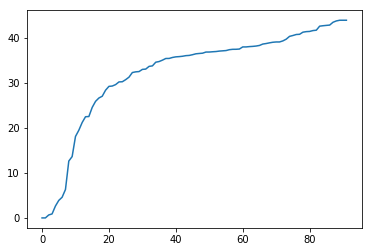

In [68]:
plt.plot(eigenvalues)

We can see that there are very few eigenvalue close to 0. The eigenvalues are big after the second eigenvalue.

#### How many connected components are there in your graph? Answer using the eigenvalues only.

Since we know that the multiplicity of the eigenvalue 0 give us the number of connected components in our graph. We can conclude that our graph has 2 connected components

#### Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

The largest possible eigenvalue for the normalized Laplacian is 2.

The largest possible eigenvalue for the combinatorial Laplacian is the trace of D (sum of all degrees). Indeed as $Tr(L) = \sum_i \lambda_i$ and that by construction $Tr(L) = Tr(D)$, the largest eigenvalue cannot exceed this.

## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

### Question 7

#### What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

Laplacian eigenmaps are used to reduce the dimensionality of each datapoint such that similar points in high dimension are embedded close to each other in lower dimension.

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

In [155]:
partial_eigenvalues, partial_eigenvectors = sparse.linalg.eigsh(laplacian_normalized, 3, which ='SM',v0=np.ones(n_nodes))

In [156]:
indexes = np.argsort(partial_eigenvalues)
partial_eigenvalues = partial_eigenvalues[indexes]
partial_eigenvectors = partial_eigenvectors[:,indexes]

In [164]:
embedding = partial_eigenvectors[:,0:2].copy()

In [165]:
embedding = np.real(embedding)
embedding_normalized = D_half @ embedding

#### Plot the nodes embedded in 2D. Comment on what you see.

The embedding from the unnormalized eigenvector

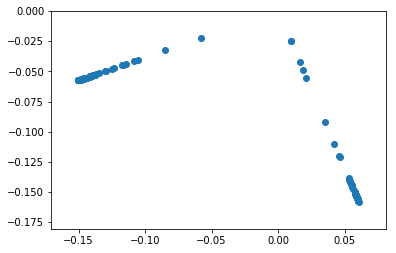

In [166]:
plt.scatter(embedding[:,0],embedding[:,1])

The embedding from the normalized eigenvector

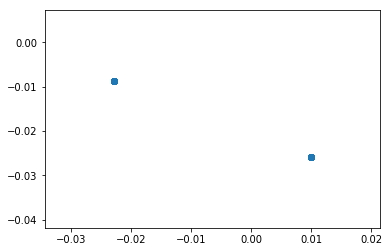

In [167]:
plt.scatter(embedding_normalized[:,0],embedding_normalized[:,1])

As we expected we can clearly see two clusters and some outliers. This depict the fact that there are two main parties (Republicans and Democrats) and some independant parties.

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

The embedding that we obtain from the Laplacian eigenmaps is optimal with respect to locality preservation.

Indeed as we are minimizing (without the trivial solution):
$$arg \; min_{y_1,...,y_N} \sum_{i~j} W(i, j) \cdot ||y_i - y_j||^2_2$$

We will preserve closeness,as small distance between two points i and j will imply a large weight $w_{ij}$. Hence in the minimisation process $y_i$ and $y_j$ will have to be close to each other, such that $||y_i - y_j||^2_2$ is small to reduce the impact of $w_{ij}$.

## 2 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

Assuming that we have 2 distinct groups of republican and democrats, we should try k = 2 , or k = 3 to account for independent candidates. We also see that the there is a gap in the Laplacian spectrum after the second eigenvalue, this indicate that there is most likely two clusters.

**TODO** : FOR d?

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
1. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

- We start clustering our nodes in two large clusters

In [205]:
def embed(laplacian,d):
    eigenvalues,eigenvectors =  scipy.linalg.eigh(laplacian)
    indexes = np.argsort(eigenvalues)

    return eigenvectors[:,indexes][:,:d]

embedding_spectral = embed(laplacian.todense(),2)
embedding_spectral_normalized = D_half @ embed(laplacian.todense(),2)

Number of elements in right cluster (47,)
Number of elements in left cluster (45,)


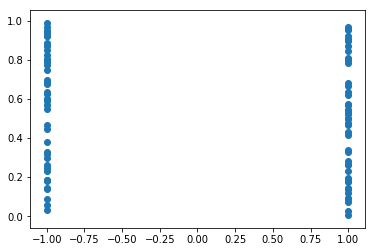

In [206]:
def fielder(eigenvectors):
    return np.sign(eigenvectors[:,1])

fielder_vector = fielder(embedding_spectral) 

plt.scatter(fielder_vector,np.random.rand(n_nodes))
print('Number of elements in right cluster {}'.format(fielder_vector[fielder_vector>0].shape))
print('Number of elements in left cluster {}'.format(fielder_vector[fielder_vector<0].shape))

- We then try to cluster the nodes in 3 clusters in order to take into account the presence of independant senators in our dataset

In [239]:
embedding_spectral = embed(laplacian.todense(),5)
k = 3

def gen_kmeans(k,eigenvectors,random_state = 42):
    means = KMeans(n_clusters=k, random_state=random_state).fit(eigenvectors)
    return means.labels_

clusters = gen_kmeans(k,embedding_spectral)

Number of nodes in Cluster 1 is 42
Number of nodes in Cluster 2 is 49
Number of nodes in Cluster 3 is 1


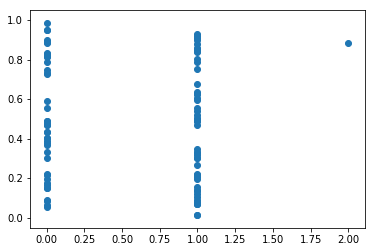

In [240]:
plt.scatter(clusters,np.random.rand(n_nodes))

for i in range(k):
    print('Number of nodes in Cluster {} is {}'.format(i+1,clusters[clusters==i].shape[0]))

### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

We expected to see two clear squared matrix representing the two parties.

In [241]:
idx = []

for i in range(k):
    idx += (list(np.argwhere(clusters == i).ravel()))

In [242]:
adjacency_reordered = adjacency[np.ix_(idx,idx)]

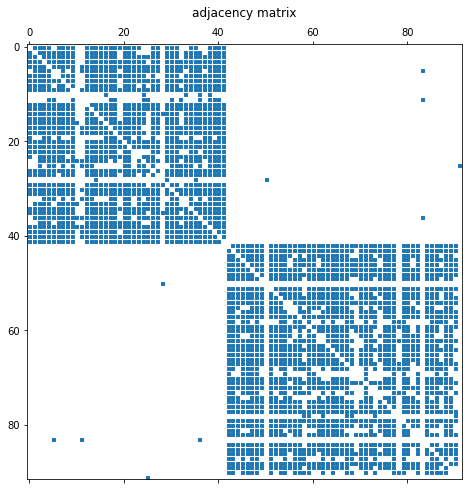

In [243]:
plt.figure(figsize=(8,8))
plt.spy(adjacency_reordered, markersize=3)
plt.title('adjacency matrix')
plt.show()

As expected we get two clear clusters

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

In [244]:
labels = ['R','D','I']

def get_assignement(kmeans_labels,original_labels,labels = ['R','D','I'],k=3):
    """ Match between clusters returned by the kmean algorithm and the dataset original labels
    
    Parameters
    ----------
    kmeans_labels: list
        List of nodes labeled by their corresponding predicted cluster
    original_labels: list
        List of nodes labeled by their original label index
    labels: list.
        List of original label names
    k: int
        Number of clusters
    
    Returns
    -------
    dict_cluster_to_party: dict
        Dictionary where the key is a original label and the value is its corresponding kmean cluster index.
    """
    assigned_cluster = []
    clusters = list(range(k))    
    index_labels = []

    dict_cluster_to_party = dict()
    
    for label in labels:
        index_labels.append((label,np.where(original_labels == label)[0]))

    index_labels.sort(key = lambda x: len(x[1]),reverse= True)
    
    for idx in index_labels:
        
        temp = kmeans_labels[idx[1]]
        temp = [x for x in temp if x not in assigned_cluster]
        if len(temp) == 0:
            cluster_chosen = clusters[0]
            assigned_cluster.append(cluster_chosen)
            clusters.remove(cluster_chosen)
            dict_cluster_to_party[idx[0]] = cluster_chosen
        else: 
            most_commun_item = np.bincount(kmeans_labels[idx[1]]).argmax()
            assigned_cluster.append(most_commun_item)
            clusters.remove(most_commun_item)
            dict_cluster_to_party[idx[0]] = most_commun_item
        
    return dict_cluster_to_party
        
def compare_truth(kmeans_labels,original_labels,dict_):
    """ Compute the accuracy of the spectral clustering
    
    Parameters
    ----------
    kmeans_labels: list
        List of nodes labeled by their corresponding predicted cluster
    original_labels: list
        List of nodes labeled by their original label index
    dict_: dict.
        mapping between kmean clusters and original labels
    
    Returns
    -------
    ret: float
        clustering accuracy
    """
    original_labels_copy = original_labels.copy()
    
    for label in labels:
        original_labels_copy[original_labels_copy == label] = dict_[label]
    original_labels_copy = original_labels_copy.flatten()
    
    ret = (original_labels_copy == kmeans_labels).sum() / kmeans_labels.shape[0]
    return ret
    
dict_party_to_cluster = get_assignement(clusters,members_parties)
dict_cluster_to_party = {v: k for k, v in dict_party_to_cluster.items()}
print('The clustering accuracy is {:.5f}'.format(compare_truth(clusters,members_parties,dict_party_to_cluster)))

The clustering accuracy is 0.94565


### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

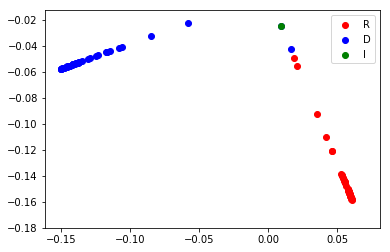

In [245]:
colors = ['r','b','g']

for i in range(k):
    idx = np.argwhere(clusters == i).flatten()
    plt.scatter(embedding[idx,0],embedding[idx,1],c=colors[i])
plt.legend([dict_cluster_to_party[i] for i in range(k)])

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

We use the eigenvectors of the Laplacian because they represent the structure of the graph. We could also have used the eigenvectors of the adjacency matrix for clustering.